In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

2025-01-17 21:46:07.026505: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Constants
FRED_API_KEY = "b24786a45dd3d34325a8958a2e7d8d13"
fred = Fred(api_key=FRED_API_KEY)

start_date = '2018-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

tickers = ['AAPL', 'TSLA', 'NVDA', 'XOM', 'PFE', 'TTWO']

# Helper Functions
def annualized_return(returns, freq=252):
    cum_ret = (1 + returns).prod()
    n_periods = returns.shape[0]
    return cum_ret ** (freq / n_periods) - 1

def annualized_volatility(returns, freq=252):
    """
    Convert a series of returns to annualized volatility.
    """
    return returns.std() * np.sqrt(freq)

# Data Pulling Functions
def get_yahoo_data(ticker_list, start_date, end_date):
    """
    Returns a dictionary of DataFrames: { 'prices': prices_df, 'eps': eps_df }
    """
    
    # 1) Price data 
    prices = yf.download(ticker_list, start=start_date, end=end_date)['Adj Close']
    
    # 2) EPS data (quarterly) - Illustrative approach, limited by yfinance
    eps_data = {}
    for ticker in ticker_list:
        tk = yf.Ticker(ticker)
        try:
            # "quarterly_earnings" is not guaranteed to exist or be consistent
            q_earnings = tk.quarterly_earnings
            q_earnings.columns = [col.lower() for col in q_earnings.columns]
            if 'eps' in q_earnings.columns:
                eps_data[ticker] = q_earnings['eps']
            else:
                eps_data[ticker] = pd.Series(dtype=float)
        except:
            eps_data[ticker] = pd.Series(dtype=float)
    
    eps_df = pd.DataFrame(eps_data)
    return {'prices': prices, 'eps': eps_df}

def get_fred_data(fred_symbols, start_date, end_date):
    """
    Pull multiple series from FRED.
    Returns a DataFrame with columns = fred_symbols and a DateTime index.
    fred_symbols: dict, e.g. {'GDP': 'GDP', 'TENYR': 'DGS10'}
    """
    fred_df = pd.DataFrame()
    for col_name, fred_id in fred_symbols.items():
        series_data = fred.get_series(
            fred_id, 
            observation_start=start_date, 
            observation_end=end_date
        )
        fred_df[col_name] = series_data
    fred_df.index = pd.to_datetime(fred_df.index)
    return fred_df


If SSL Error comes up on Mac for FRED API, run the following command in terminal:
- pip install --upgrade --force-reinstall certifi
 OR 
- /Applications/Python\ 3.11/Install\ Certificates.command

In [5]:
#Pull stock price & EPS data
data_dict = get_yahoo_data(tickers, start_date, end_date)
prices = data_dict['prices']
eps_df = data_dict['eps']  # Quarterly data (if available)
prices.to_csv('prices.csv')
eps_df.to_csv('eps_df.csv')

#Pull macro data from FRED
fred_symbols = {
    'GDP': 'GDP',    # Real Gross Domestic Product (Quarterly)
    'TENYR': 'DGS10' # 10-Year Treasury Constant Maturity Rate (Daily)
    # Add others if desired, e.g. 'BAML_CREDIT_SPREAD': 'BAMLC0A4CBBBEY'
}

#Export to CSV if needed 

# fred_df= pd.read_csv('fred_data.csv')
# prices= pd.read_csv('prices.csv')
# eps_df= pd.read_csv('eps_df.csv')

# Resample to daily (fill forward) to align with daily returns

fred_df = get_fred_data(fred_symbols, start_date, end_date)
fred_df = fred_df.resample('D').last().fillna(method='ffill').dropna()
fred_df.to_csv('fred_data.csv')

[*********************100%%**********************]  6 of 6 completed


In [6]:
# Compute daily returns
returns_df = prices.pct_change().dropna()

# Basic historical stats (annualized)
historical_mean_returns = returns_df.mean() * (252) #square root only applies for volatility
historical_vols = returns_df.std() * np.sqrt(252)

print("Historical Mean Returns (Annualized):")
print(historical_mean_returns)

print("\nHistorical Volatilities (Annualized):")
print(historical_vols)

Historical Mean Returns (Annualized):
Ticker
AAPL    0.292876
NVDA    0.602631
PFE     0.034855
TSLA    0.624388
TTWO    0.131559
XOM     0.133183
dtype: float64

Historical Volatilities (Annualized):
Ticker
AAPL    0.305494
NVDA    0.515424
PFE     0.253694
TSLA    0.637576
TTWO    0.352432
XOM     0.309353
dtype: float64


In [7]:
# Cell 4: Forecast Returns & Volatility using LSTM Model
forecast_horizon = 15
lstm_forecasts = {}

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

for ticker in tickers:
    # 1) Extract and scale the data
    ts = returns_df[ticker].dropna().values.reshape(-1, 1)
    scaler = MinMaxScaler()
    ts_scaled = scaler.fit_transform(ts)
    
    # 2) Create sequences for LSTM
    seq_length = 60  # Use last 60 days to predict next day
    X, y = create_sequences(ts_scaled, seq_length)
    
    # 3) Build and train LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    # Reshape X for LSTM input (samples, time steps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Train the model
    model.fit(X, y, epochs=50, batch_size=32, verbose=0)
    
    # 4) Generate forecasts
    last_sequence = ts_scaled[-seq_length:].reshape(1, seq_length, 1)
    forecast_scaled = []
    
    for _ in range(forecast_horizon):
        next_pred = model.predict(last_sequence, verbose=0)
        forecast_scaled.append(next_pred[0, 0])
        last_sequence = np.roll(last_sequence, -1)
        last_sequence[0, -1, 0] = next_pred[0, 0]
    
    # 5) Inverse transform predictions
    forecast_values = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))
    
    # 6) Store the mean forecast
    lstm_forecasts[ticker] = np.mean(forecast_values)

lstm_forecasts_series = pd.Series(lstm_forecasts, name='LSTMForecastedReturn')
print("LSTM-based Forecast Returns (Avg. Over Next 15 Days):")
print(lstm_forecasts_series)

#pull latest GDP and 10 year treasury rate
latest_gdp = fred_df['GDP'].iloc[-1]
latest_rate = fred_df['TENYR'].iloc[-1]

gdp_series = fred_df['GDP']
gdp_growth = (gdp_series.iloc[-1] / gdp_series.iloc[-4] - 1)  # Year-over-year growth

# Interest rates are already in percentage form, just convert to decimal
rate_decimal = latest_rate / 100

# Compute factor adjustment using growth rates
factor_adjustment = gdp_growth - rate_decimal

# Update the rest of the code to use lstm_forecasts_series instead of theta_forecasts_series
adjusted_forecasts = []
for ticker in tickers:
    base_forecast = lstm_forecasts_series[ticker]
    adjusted_value = base_forecast * (1 + factor_adjustment)
    adjusted_forecasts.append(adjusted_value)

adjusted_forecasts_series = pd.Series(adjusted_forecasts, index=tickers, name='AdjustedForecastedReturn')
print("\nAdjusted Forecast Returns (with GDP & Rates):")
print(adjusted_forecasts_series)


# Forecast Volatility (Illustrative: use rolling std of returns)
rolling_window = 30  # last 30 days
vol_forecasts = returns_df.rolling(rolling_window).std().iloc[-1, :] * np.sqrt(252)
vol_forecasts.name = 'ForecastedVolatility'

print("\nForecasted Volatility (simple rolling 30-day):")
print(vol_forecasts)

LSTM-based Forecast Returns (Avg. Over Next 15 Days):
AAPL    0.002215
TSLA    0.009901
NVDA   -0.003004
XOM    -0.002214
PFE    -0.001624
TTWO    0.001557
Name: LSTMForecastedReturn, dtype: float32

Adjusted Forecast Returns (with GDP & Rates):
AAPL    0.002143
TSLA    0.009580
NVDA   -0.002906
XOM    -0.002142
PFE    -0.001572
TTWO    0.001507
Name: AdjustedForecastedReturn, dtype: float64

Forecasted Volatility (simple rolling 30-day):
Ticker
AAPL    0.222245
NVDA    0.413265
PFE     0.224910
TSLA    0.687960
TTWO    0.232504
XOM     0.174911
Name: ForecastedVolatility, dtype: float64


In [17]:
#PCA (Testing)

eps_growth = {}
for ticker in tickers:
    ts_eps = eps_df[ticker].dropna()
    if len(ts_eps) >= 2:
        eps_growth[ticker] = ts_eps.iloc[-1] / ts_eps.iloc[-2] - 1
    else:
        eps_growth[ticker] = 0.0

factors_list = []
for ticker in tickers:
    row_dict = {
        'Ticker': ticker,
        'AdjForecastReturn': adjusted_forecasts_series[ticker],
        'GDP': latest_gdp,
        'Rates': latest_rate,
        'EPS_Growth': eps_growth[ticker]
    }
    factors_list.append(row_dict)

factors_df = pd.DataFrame(factors_list)
print("\nFactor DataFrame:")
print(factors_df)

# (Optional) PCA to reduce dimensionality of the factors
factors_for_pca = factors_df[['AdjForecastReturn', 'GDP', 'Rates', 'EPS_Growth']].copy()
scaler = StandardScaler()
factors_scaled = scaler.fit_transform(factors_for_pca)

pca = PCA(n_components=2)  # or keep more components if you prefer
pca_data = pca.fit_transform(factors_scaled)

print("\nExplained Variance Ratio of PCA Components:")
print(pca.explained_variance_ratio_)

# Add information about preserved factors
print("\nFactor Loadings (Component Weights):")
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=['AdjForecastReturn', 'GDP', 'Rates', 'EPS_Growth']
)
print(loadings)


pca_results_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
pca_results_df['Ticker'] = factors_df['Ticker'].values
print("\nPCA Transformed Factors:")
print(pca_results_df)

#From this, we can see that PCA is not necessary and not very insightful so it will not be used or implemented any further


Factor DataFrame:
  Ticker  AdjForecastReturn        GDP  Rates  EPS_Growth
0   AAPL           0.002143  29374.914   4.48         0.0
1   TSLA           0.009580  29374.914   4.48         0.0
2   NVDA          -0.002906  29374.914   4.48         0.0
3    XOM          -0.002142  29374.914   4.48         0.0
4    PFE          -0.001572  29374.914   4.48         0.0
5   TTWO           0.001507  29374.914   4.48         0.0

Explained Variance Ratio of PCA Components:
[1. 0.]

Factor Loadings (Component Weights):
                   PC1  PC2
AdjForecastReturn  1.0  0.0
GDP                0.0  0.0
Rates              0.0  1.0
EPS_Growth         0.0  0.0

PCA Transformed Factors:
        PC1  PC2 Ticker
0  0.246828  0.0   AAPL
1  2.008954  0.0   TSLA
2 -0.949651  0.0   NVDA
3 -0.768668 -0.0    XOM
4 -0.633465 -0.0    PFE
5  0.096001  0.0   TTWO


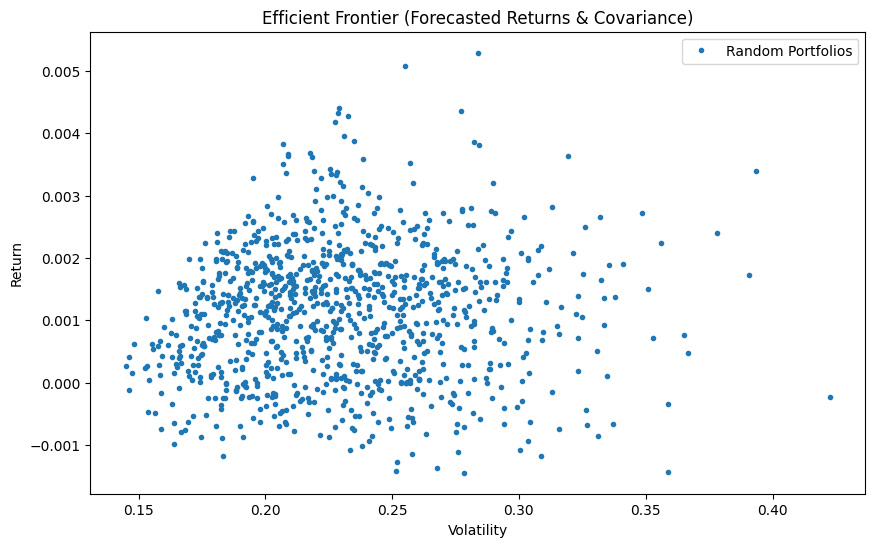

In [13]:
#Mean-Variance Optimization & Efficient Frontier

# Build a forecast covariance matrix using historical correlation + forecasted vol
historical_corr = returns_df.corr()                 # shape 6x6
diag_vol = np.diag(vol_forecasts.values)            # shape 6x6
cov_forecast = diag_vol @ historical_corr.values @ diag_vol  # shape 6x6

# Forecasted return vector = adjusted forecasts
mu = adjusted_forecasts_series.values  # shape (6,)
Sigma = cov_forecast                   # shape (6,6)

def portfolio_performance(weights, mu, Sigma):
    """
    Given portfolio weights, expected returns (mu), and covariance (Sigma),
    returns (expected_return, volatility).
    """
    ret = weights @ mu
    vol = np.sqrt(weights @ Sigma @ weights)
    return ret, vol

# Let's brute-force random weights to plot an approximate efficient frontier
n_points = 1000
results = []
for _ in range(n_points):
    w = np.random.rand(len(tickers))
    w /= w.sum()
    ret, vol = portfolio_performance(w, mu, Sigma)
    results.append((w, ret, vol))

frontier_df = pd.DataFrame(results, columns=['Weights', 'Return', 'Vol'])
frontier_df.sort_values('Vol', inplace=True)

# Plot the Efficient Frontier
plt.figure(figsize=(10, 6))
plt.plot(frontier_df['Vol'], frontier_df['Return'], 'o', markersize=3, label='Random Portfolios')
plt.title('Efficient Frontier (Forecasted Returns & Covariance)')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.show()


Equal-Weighted Portfolio Return: 0.0011, Volatility: 0.2219


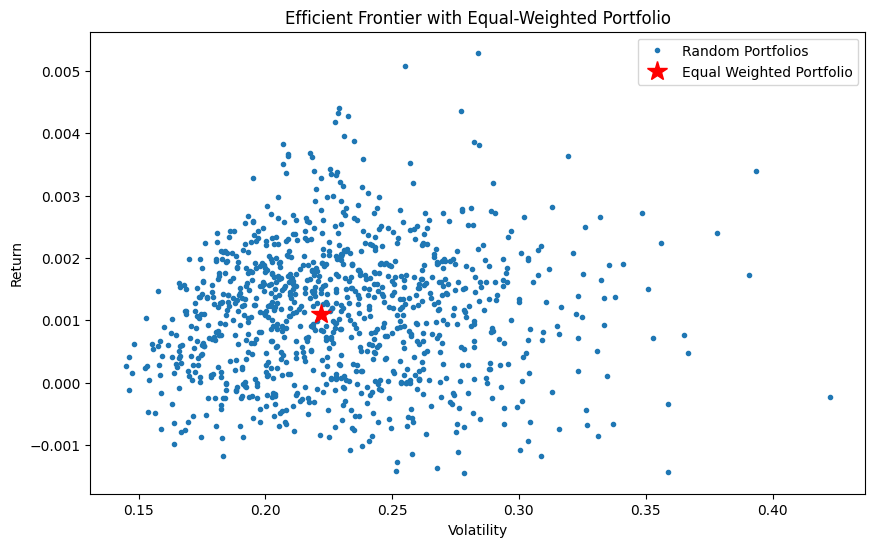

In [14]:
# Compare with Equal-Weighted Portfolio
equal_w = np.ones(len(tickers)) / len(tickers)
eq_ret, eq_vol = portfolio_performance(equal_w, mu, Sigma)
print(f"Equal-Weighted Portfolio Return: {eq_ret:.4f}, Volatility: {eq_vol:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(frontier_df['Vol'], frontier_df['Return'], 'o', markersize=3, label='Random Portfolios')
plt.plot(eq_vol, eq_ret, 'r*', markersize=15, label='Equal Weighted Portfolio')
plt.title('Efficient Frontier with Equal-Weighted Portfolio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.show()

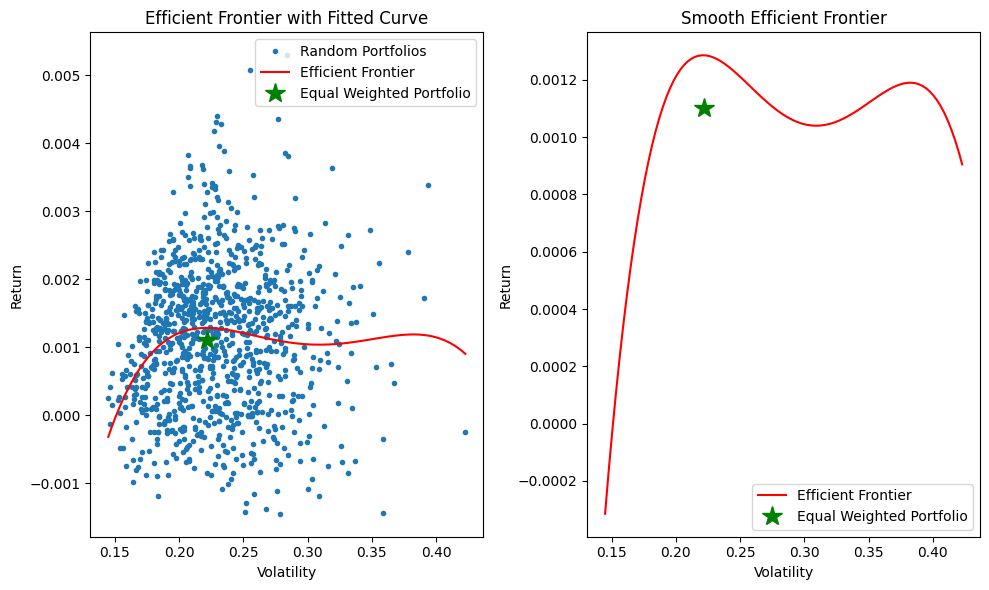

In [15]:
# Draw the efficient frontier curve 
# Fit a polynomial to the efficient frontier points
z = np.polyfit(frontier_df['Vol'], frontier_df['Return'], 4)
p = np.poly1d(z)

# Create a smooth curve using the polynomial
x_range = np.linspace(frontier_df['Vol'].min(), frontier_df['Vol'].max(), 100)
y_range = p(x_range)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# First subplot: Original scatter with fitted curve
ax1.plot(frontier_df['Vol'], frontier_df['Return'], 'o', markersize=3, label='Random Portfolios')
ax1.plot(x_range, y_range, 'r-', label='Efficient Frontier')
ax1.plot(eq_vol, eq_ret, 'g*', markersize=15, label='Equal Weighted Portfolio')
ax1.set_title('Efficient Frontier with Fitted Curve')
ax1.set_xlabel('Volatility')
ax1.set_ylabel('Return')
ax1.legend()

# Second subplot: Just the fitted curve
ax2.plot(x_range, y_range, 'r-', label='Efficient Frontier')
ax2.plot(eq_vol, eq_ret, 'g*', markersize=15, label='Equal Weighted Portfolio')
ax2.set_title('Smooth Efficient Frontier')
ax2.set_xlabel('Volatility')
ax2.set_ylabel('Return')
ax2.legend()

plt.tight_layout()
plt.show()


Global Minimum Variance Portfolio:
Weights    [0.175555811104702, 0.04612453409682283, 0.286...
Return                                              0.000261
Vol                                                 0.144902
Name: 586, dtype: object


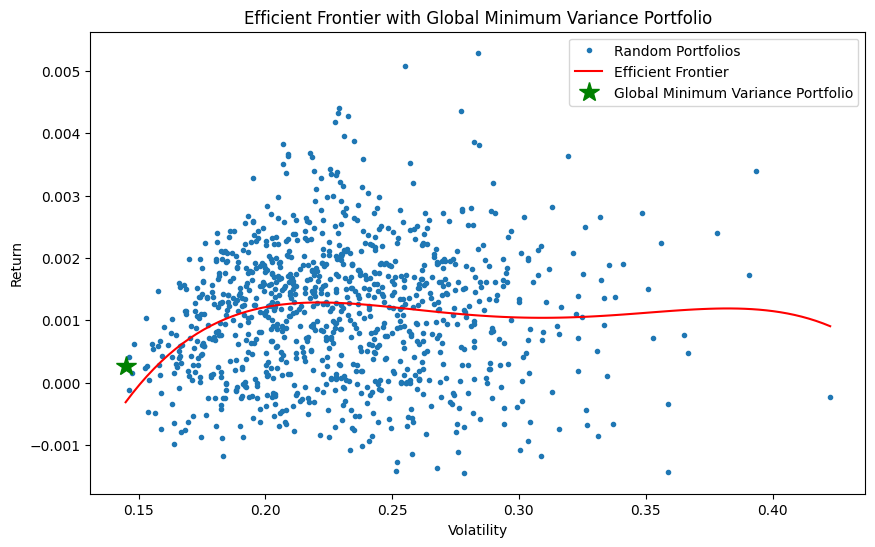

In [16]:
#global minimum variance portfolio
global_min_var = frontier_df.iloc[np.argmin(frontier_df['Vol'])]
print("Global Minimum Variance Portfolio:")
print(global_min_var)

#plot the global minimum variance portfolio on the efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(frontier_df['Vol'], frontier_df['Return'], 'o', markersize=3, label='Random Portfolios')
plt.plot(x_range, y_range, 'r-', label='Efficient Frontier')
plt.plot(global_min_var['Vol'], global_min_var['Return'], 'g*', markersize=15, label='Global Minimum Variance Portfolio')
plt.title('Efficient Frontier with Global Minimum Variance Portfolio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.show()
